In [51]:
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
from collections import defaultdict, Counter
from scipy import signal
import numpy as np
import librosa
import random as rn
from keras.layers import Dense
from keras import Input
from keras.engine import Model
from keras import optimizers
from keras.utils import to_categorical
from keras.layers import Dense, TimeDistributed, Dropout, Bidirectional, GRU, BatchNormalization, Activation, LeakyReLU, LSTM, Flatten, RepeatVector, Permute, Multiply, Conv2D, MaxPooling2D

In [52]:
DATA_DIR = 'C:/Users/JLK/Downloads/free-spoken-digit-dataset-master/recordings/'
#DATA_DIR = 'C:/Users/JLK/requirements/recordings/'

In [53]:
import sys
print(sys.version)

3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]


In [54]:
y, sr = librosa.load('0_jackson_0.wav')
y.shape

(14190,)

In [103]:
import sox

In [104]:
sr = sox.file_info.sample_rate('0_jackson_0.wav')

8000.0

In [126]:
librosa.get_samplerate('0_jackson_0.wav')

8000

In [133]:
wav, sr = librosa.load('C:/Users/JLK/Downloads/free-spoken-digit-dataset-master/recordings/0_jackson_0.wav', sr=None)

In [135]:
sr

8000

In [153]:
wav, sr = librosa.load('C:/Users/JLK/Downloads/free-spoken-digit-dataset-master/recordings/0_jackson_0.wav', sr=None)
mfcc = librosa.feature.mfcc(wav)

In [154]:
mfcc.shape

(20, 11)

In [155]:
mfcc[1]

array([122.379776 ,  76.30391  ,  32.959167 ,  -2.9676604,   2.931554 ,
        36.501152 ,  55.442417 ,  62.885284 ,  76.6254   , 102.49776  ,
       117.29262  ], dtype=float32)

In [156]:
padded_mfcc = pad2d(mfcc, 40)

In [157]:
padded_mfcc.shape

(20, 40)

In [158]:
padded_mfcc

array([[-272.63790894, -238.88999939, -174.43241882, -130.81161499,
        -108.58714294,  -99.63011932, -112.40315247, -159.37634277,
        -232.54632568, -326.81069946, -405.04373169,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ],
       [ 122.379776  ,   76.3039093 ,   32.95916748,   -2.96766043,
           2.93155408,   36.50115204,   55.44241714,   62.88528442,
          76.62539673,  102.49775696,  117.2926178 ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.    

In [136]:
test_speaker = 'theo'
train_X = []
train_spectrograms = []
train_mel_spectrograms = []
train_mfccs = []
train_y = []

test_X = []
test_spectrograms = []
test_mel_spectrograms = []
test_mfccs = []
test_y = []

#a(음성:wave)랑 i를 받아서 a[0:i] 크기만큼을 return 함. (a.shape가 i보다 클 경우.) 아니라면 i의 크기에서 모자란 만큼 0으로 초기화 한 값
pad1d = lambda a, i: a[0: i] if a.shape[0] > i else np.hstack((a, np.zeros(i - a.shape[0])))
pad2d = lambda a, i: a[:, 0: i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0],i - a.shape[1]))))
#STFT한 것, CNN분석하기 위해 Spectogram으로 만든 것, MF한 것, mel-spectogram한 것


for fname in os.listdir(DATA_DIR):
    try:
        if '.wav' not in fname or 'dima' in fname:
            continue
        struct = fname.split('_')
        digit = struct[0]
        speaker = struct[1]
        wav, sr = librosa.load(DATA_DIR + fname, sr=sr)
        padded_x = pad1d(wav, 30000)
        #librosa.stft(y)를 통해 스펙트럼을 얻는다.
        #
        spectrogram = np.abs(librosa.stft(wav, n_fft=512))
        padded_spectogram = pad2d(spectrogram, 40)
        
        mel_spectogram = librosa.feature.melspectrogram(wav)
        padded_mel_spectrogram = pad2d(mel_spectogram, 40)
        
        mfcc = librosa.feature.mfcc(wav)
        padded_mfcc = pad2d(mfcc, 40)
        
        if speaker == test_speaker:
            test_X.append(padded_x)
            test_spectrograms.append(padded_spectogram)
            test_mel_spectrograms.append(padded_mel_spectrogram)
            test_mfccs.append(padded_mfcc)
            test_y.append(digit)
        else:
            train_X.append(padded_x)
            train_spectrograms.append(padded_spectogram)
            train_mel_spectrograms.append(padded_mel_spectrogram)
            train_mfccs.append(padded_mfcc)
            train_y.append(digit)
    except Exception as e:
        print(fname, e)
        raise
        
train_X = np.vstack(train_X)
train_spectrograms = np.array(train_spectrograms)
train_mel_spectrograms = np.array(train_mel_spectrograms)
train_mfccs = np.array(train_mfccs)
train_y = to_categorical(np.array(train_y))

test_X = np.vstack(test_X)
test_spectrograms = np.array(test_spectrograms)
test_mel_spectrograms = np.array(test_mel_spectrograms)
test_mfccs = np.array(test_mfccs)
test_y = to_categorical(np.array(test_y))

print('train_X:', train_X.shape)
print('train_spectrograms:', train_spectrograms.shape)
print('train_mel_spectrograms', train_mel_spectrograms.shape)
print('train_mfccs', train_mfccs.shape)
print('train_y', train_y.shape)

print('test_X', test_X.shape)
print('test_spectrograms', test_spectrograms.shape)
print('test_mel_spectrograms', test_mel_spectrograms.shape)
print('test_mfccs', test_mfccs.shape)
print('test_y', test_y.shape)

train_X: (2500, 30000)
train_spectrograms: (2500, 257, 40)
train_mel_spectrograms (2500, 128, 40)
train_mfccs (2500, 20, 40)
train_y (2500, 10)
test_X (500, 30000)
test_spectrograms (500, 257, 40)
test_mel_spectrograms (500, 128, 40)
test_mfccs (500, 20, 40)
test_y (500, 10)


In [137]:
wav

array([-6.1035156e-05, -2.7465820e-04, -1.5258789e-04, ...,
       -3.0517578e-04,  6.1035156e-05, -1.2207031e-04], dtype=float32)

In [138]:
test_spectrograms[0]

array([[0.0165965 , 0.01481539, 0.01545923, ..., 0.        , 0.        ,
        0.        ],
       [0.0136071 , 0.00355694, 0.00794592, ..., 0.        , 0.        ,
        0.        ],
       [0.01585379, 0.01097529, 0.00500691, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00137991, 0.0024028 , 0.00057527, ..., 0.        , 0.        ,
        0.        ],
       [0.00291335, 0.00348159, 0.00275965, ..., 0.        , 0.        ,
        0.        ],
       [0.00563096, 0.00349552, 0.00112412, ..., 0.        , 0.        ,
        0.        ]])

In [139]:
train_X_ex = np.expand_dims(train_mfccs, -1)
test_X_ex = np.expand_dims(test_mfccs, -1)
print('train X shape:', train_X_ex.shape)
print('test X shape:', test_X_ex.shape)

train X shape: (2500, 20, 40, 1)
test X shape: (500, 20, 40, 1)


In [140]:
ip = Input(shape=train_X_ex[0].shape)
m = Conv2D(64, kernel_size=(4,4), activation='relu')(ip)
m = MaxPooling2D(pool_size=(4,4))(m)


m=Flatten()(m)
m=Dense(32, activation='relu')(m)
op=Dense(10, activation='softmax')(m)

model = Model(ip, op)

model.summary()

Model: "functional_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 20, 40, 1)]       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 17, 37, 64)        1088      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 4, 9, 64)          0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 2304)              0         
_________________________________________________________________
dense_43 (Dense)             (None, 32)                73760     
_________________________________________________________________
dense_44 (Dense)             (None, 10)                330       
Total params: 75,178
Trainable params: 75,178
Non-trainable params: 0
_________________________________________________

In [141]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_X_ex,
                    train_y,
                    epochs=100,
                    batch_size=32,
                    verbose=1,
                    validation_data=(test_X_ex, test_y))

Epoch 1/100
79/79 [==============================] - 1s 8ms/step - loss: 3.3553 - accuracy: 0.1456 - val_loss: 2.6310 - val_accuracy: 0.1400
Epoch 2/100
79/79 [==============================] - 1s 7ms/step - loss: 2.1006 - accuracy: 0.2512 - val_loss: 2.3631 - val_accuracy: 0.2120
Epoch 3/100
79/79 [==============================] - 1s 7ms/step - loss: 1.8374 - accuracy: 0.3464 - val_loss: 2.1726 - val_accuracy: 0.2160
Epoch 4/100
79/79 [==============================] - 1s 7ms/step - loss: 1.6242 - accuracy: 0.4280 - val_loss: 1.9534 - val_accuracy: 0.3220
Epoch 5/100
79/79 [==============================] - 1s 7ms/step - loss: 1.4184 - accuracy: 0.5188 - val_loss: 1.8540 - val_accuracy: 0.3560
Epoch 6/100
79/79 [==============================] - 1s 7ms/step - loss: 1.2152 - accuracy: 0.5980 - val_loss: 1.7056 - val_accuracy: 0.4260
Epoch 7/100
79/79 [==============================] - 1s 7ms/step - loss: 1.0449 - accuracy: 0.6696 - val_loss: 1.5751 - val_accuracy: 0.4620
Epoch 8/100
7

Epoch 59/100
79/79 [==============================] - 1s 7ms/step - loss: 0.0304 - accuracy: 0.9968 - val_loss: 0.7670 - val_accuracy: 0.8180
Epoch 60/100
79/79 [==============================] - 1s 7ms/step - loss: 0.0229 - accuracy: 0.9984 - val_loss: 0.7985 - val_accuracy: 0.8100
Epoch 61/100
79/79 [==============================] - 1s 7ms/step - loss: 0.0230 - accuracy: 0.9988 - val_loss: 0.8186 - val_accuracy: 0.8020
Epoch 62/100
79/79 [==============================] - 1s 7ms/step - loss: 0.0204 - accuracy: 0.9988 - val_loss: 0.7821 - val_accuracy: 0.8120
Epoch 63/100
79/79 [==============================] - 1s 7ms/step - loss: 0.0194 - accuracy: 0.9988 - val_loss: 0.8457 - val_accuracy: 0.7980
Epoch 64/100
79/79 [==============================] - 1s 7ms/step - loss: 0.0222 - accuracy: 0.9984 - val_loss: 0.7944 - val_accuracy: 0.8100
Epoch 65/100
79/79 [==============================] - 1s 7ms/step - loss: 0.0185 - accuracy: 0.9988 - val_loss: 0.7915 - val_accuracy: 0.8100
Epoch 

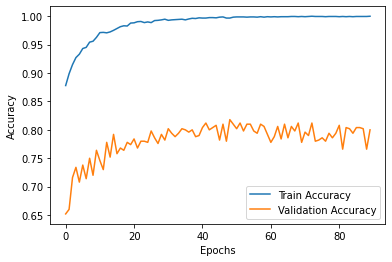

In [142]:
plt.plot(history.history['accuracy'][10:], label='Train Accuracy')
plt.plot(history.history['val_accuracy'][10:], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

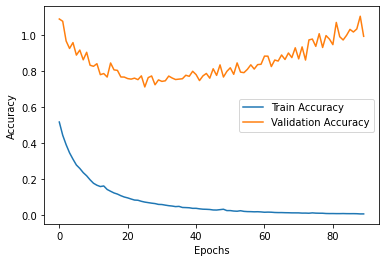

In [143]:
plt.plot(history.history['loss'][10:], label='Train Accuracy')
plt.plot(history.history['val_loss'][10:], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [144]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

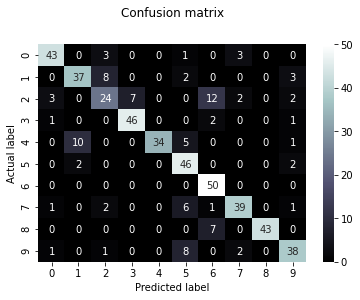

In [145]:
Y_pred = model.predict(test_X_ex)
y_pred = np.argmax(Y_pred,axis=1)

matrix = confusion_matrix(np.argmax(test_y,axis=1), y_pred)
sns.heatmap(pd.DataFrame(matrix), annot=True, cmap="bone" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()